# import libraries and data 

In [ ]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('data.csv')

In [3]:
data.shape

(20972, 9)

In [4]:
data.head(5)

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


# preprocces of data 

In [5]:
data.columns = [i.lower().replace(' ','_') for i in data.columns]

In [6]:
data.head(1)

,id,title,abstract,computer_science,physics,mathematics,statistics,quantitative_biology,quantitative_finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0


In [7]:
data.shape

(20972, 9)

In [8]:
data.isnull().sum()

id                      0
title                   0
abstract                0
computer_science        0
physics                 0
mathematics             0
statistics              0
quantitative_biology    0
quantitative_finance    0
dtype: int64

In [9]:
data.duplicated().sum()

0

# we have to change the outpout to a single column ! : 

In [11]:
output = data.drop(columns=['id','title','abstract']).values

In [12]:
clas = []
sub = data[['computer_science','physics','mathematics','statistics','quantitative_biology','quantitative_finance']].values
for i in sub:
    x = i.argmax(0)
    clas.append(x)



data['class'] = clas
data.drop(columns=['computer_science','physics','mathematics','statistics','quantitative_biology','quantitative_finance'],inplace=True)








In [13]:
df = data

# combine abstract with title 

In [14]:
df.head(2)

,id,title,abstract,class
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,0


In [15]:
text = []


vals = df[['title','abstract']].values


for i in vals:
    text.append(str(i[0])+str(i[1]))

df['text'] = text

In [16]:
len(vals)

20972

In [17]:
# just a check
print(len(df.loc[df['id'] == 1,'title'].values[0]))
print(len(df.loc[df['id'] == 1,'abstract'].values[0]))
print(len(df.loc[df['id'] == 1,'text'].values[0]))

43
1912
1955


### everithing is fine we can proceed 

In [18]:
df.drop(columns=['title','abstract','id'],inplace=True)

In [19]:
df = df[['text','class']]

In [20]:
df.head(3)

,text,class
0,Reconstructing Subject-Specific Effect Maps P...,0
1,Rotation Invariance Neural Network Rotation i...,0
2,Spherical polyharmonics and Poisson kernels fo...,2


# independed feature

In [21]:
x = df['text'].values

# depended feature 

In [22]:
y = df['class'].values

# subject balance

In [ ]:
cols = data.drop(columns=['id','title','abstract']).columns



import seaborn as sns
import matplotlib.pyplot as plt

x_axis = range(len(cols))
plt.figure(figsize=(5,5))
plt.bar(x_axis,data.drop(columns=['title','abstract','id']).sum())
plt.xticks(x_axis,cols,rotation=90)
plt.show()

### subjects are not that well balanced

# remove stop words

In [23]:
from nltk.corpus import stopwords
stop  = stopwords.words("english")


def remove_stop(sent):
    text = ' '.join([word for word in sent.split() if word not in stop])
    return text

In [24]:
text = []
for i in x:
    new = remove_stop(i)
    text.append(new)
    

In [25]:
x = np.array(text)

# lemmatizing words

In [26]:
from nltk.stem import WordNetLemmatizer

In [27]:
lemmatizer = WordNetLemmatizer()
 

In [30]:
def lematize(sent):
    text = ' '.join([lemmatizer.lemmatize(word) for word in sent.split()])
    return text 

In [33]:
text = []
for i in x:
    new = lematize(i)
    text.append(new)
    
x = np.array(text)    


# split in train and test 

In [35]:
from sklearn.model_selection import train_test_split as tt
x_train,x_test,y_train,y_test = tt(x,y,test_size=0.2)

# Tokenize the words

In [36]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [40]:
token = Tokenizer(num_words=40000,oov_token = 'oov_tok')

In [41]:
token.fit_on_texts(x_train)

In [42]:
len(token.word_index)

50959

In [43]:
x = np.argmax(x_train)
size_ = len(x_train[x])
size_

1330

# make sequences and pad them 

In [44]:
train_sequences = token.texts_to_sequences(x_train)
training_padded = pad_sequences(train_sequences, maxlen=size_, padding='post', truncating='post')

In [45]:
test_sequences = token.texts_to_sequences(x_test)
test_padded = pad_sequences(test_sequences, maxlen=size_, padding='post', truncating='post')

# create the input that the tensorflow expects

In [46]:
train_x = np.array(training_padded)
train_y = np.array(y_train)


test_x = np.array(test_padded)
test_y = np.array(y_test)

In [47]:
from tensorflow.keras.utils import to_categorical


train_y = to_categorical(train_y,num_classes=6)
test_y = to_categorical(test_y,num_classes=6)

# save best weights at training 

In [48]:

import tensorflow as tf

cp_callback = tf.keras.callbacks.ModelCheckpoint(monitor='vall_loss',
    filepath='model_best.h5',
                                                 save_weights_only=True,
                                                 verbose=1)

# model


In [49]:


from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import *

In [50]:
model = Sequential()

model.add(Embedding(50000,output_dim=20,input_length=size_))
model.add(GlobalAveragePooling1D())
model.add(Dense(20,'relu',kernel_regularizer='l1_l2'))
model.add(BatchNormalization())
model.add(Dense(6,'softmax'))

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1330, 20)          1000000   
                                                                 
 global_average_pooling1d (  (None, 20)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 20)                420       
                                                                 
 batch_normalization (Batch  (None, 20)                80        
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 6)                 126       
                                                                 
Total params: 1000626 (3.82 MB)
Trainable params: 10005

In [51]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [52]:
hist = model.fit(train_x,train_y,epochs=10,validation_data=(test_x,test_y),callbacks=[cp_callback])

Epoch 1/10


525/525 [==============================] - ETA: 0s - loss: 1.4479 - accuracy: 0.6690
Epoch 1: saving model to model_best.h5
525/525 [==============================] - 12s 19ms/step - loss: 1.4479 - accuracy: 0.6690 - val_loss: 1.2452 - val_accuracy: 0.6360
Epoch 2/10
525/525 [==============================] - ETA: 0s - loss: 0.8085 - accuracy: 0.7873
Epoch 2: saving model to model_best.h5
525/525 [==============================] - 10s 19ms/step - loss: 0.8085 - accuracy: 0.7873 - val_loss: 0.8364 - val_accuracy: 0.7709
Epoch 3/10
522/525 [============================>.] - ETA: 0s - loss: 0.6969 - accuracy: 0.8039
Epoch 3: saving model to model_best.h5
525/525 [==============================] - 9s 17ms/step - loss: 0.6965 - accuracy: 0.8040 - val_loss: 1.3877 - val_accuracy: 0.5190
Epoch 4/10
523/525 [============================>.] - ETA: 0s - loss: 0.6176 - accuracy: 0.8191
Epoch 4: saving model to model_best.h5
525/525 [==============================] - 10s 20ms/step - l

In [53]:
model.load_weights('model_best.h5')

# predictions and metrics 

In [100]:
preds = model.predict(test_x)

132/132 [==============================] - 1s 4ms/step


## a function to return the argmax of preds:


In [101]:
def ys(x):
    y = []
    for i in x:
        a = np.argmax(i)
        y.append(a)
    return y 
    

In [102]:
y_pred = ys(preds)
y_test = ys(test_y)

In [89]:
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,hamming_loss

## a function for metrics  : 

In [107]:
def metrics(y_pred,y_test = y_test):
    ac = accuracy_score(y_pred,y_test)
    f1 = f1_score(y_pred,y_test,average='micro')
    hloss = hamming_loss(y_pred,y_test)
    print(f'accuracy { ac}  f1 score {f1}   hammingloss {hloss}')



metrics(y_pred)

accuracy 0.6557806912991657  f1 score 0.6557806912991657   hammingloss 0.34421930870083434


<Axes: >

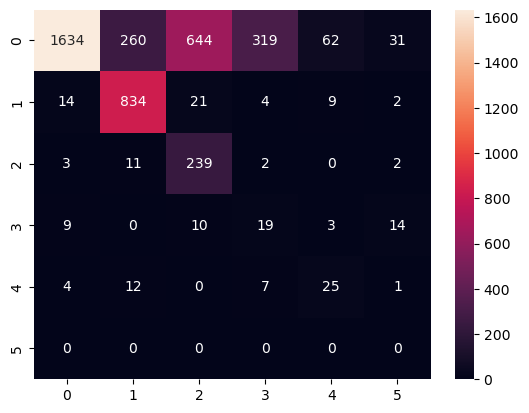

In [91]:
import seaborn as sns

cm  = confusion_matrix(y_pred,y_test)

sns.heatmap(cm,annot=True,fmt='.0f')